## Simple Hurdle Model

Run on full data

Train with logreg for classification and linreg for regression


In [1]:
# pip install
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.7 MB/s eta 0:00:00


## Loading and Preparing Data

## Final model

In [1]:
import os, sys
import importlib
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from google.colab import drive

# Force remount
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# Project path
project_path = '/content/drive/My Drive/Colab Notebooks/CIS 5200 Final Project/code'
if project_path not in sys.path:
    sys.path.append(project_path)

import flight_delay_pipeline_simple
importlib.reload(flight_delay_pipeline_simple)
from flight_delay_pipeline_simple import (
    train_model,
    hyperparameter_search,
    get_estimator,
    InferencePipeline
)

print("Successfully loaded updated pipeline!")

# Data paths
mod = "full"
DATA_FILE_PATH = "/content/drive/My Drive/Colab Notebooks/CIS 5200 Final Project/train_test_datasets/"
checkpoint_dir = "/content/drive/My Drive/Colab Notebooks/CIS 5200 Final Project/models/hurdle_linear_logistic/"

X_train_path = DATA_FILE_PATH + f'X_train_added_delay_20251202_034422.csv'
y_train_path = DATA_FILE_PATH + f'y_train_added_delay_20251202_034422.csv'
X_test_path  = DATA_FILE_PATH + f'X_test_added_delay_20251202_034422.csv'
y_test_path  = DATA_FILE_PATH + f'y_test_added_delay_20251202_034422.csv'

Mounted at /content/drive
Successfully loaded updated pipeline!


In [2]:
flight_delay_pipeline_simple

<module 'flight_delay_pipeline_simple' from '/content/drive/My Drive/Colab Notebooks/CIS 5200 Final Project/code/flight_delay_pipeline_simple.py'>

In [3]:
# Sample a subset
X_sample = pd.read_csv(X_train_path, nrows=100000)

cols_for_vif = []
for c in ['DEP_HOUR', 'DEP_TIME']:
    if c in X_sample.columns:
        cols_for_vif.append(c)

if len(cols_for_vif) >= 2:
    X_vif = X_sample[cols_for_vif].dropna()
    X_vif = sm.add_constant(X_vif)

    print("VIF for time-related features:")
    for i, col in enumerate(X_vif.columns):
        if col == 'const':
            continue
        vif_val = variance_inflation_factor(X_vif.values, i)
        print(f"{col}: VIF={vif_val:.2f}")
else:
    print("Not all of DEP_HOUR and DEP_TIME are present in the data.")

VIF for time-related features:
DEP_HOUR: VIF=475.92
DEP_TIME: VIF=475.92


In [5]:
X_sample.columns

Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'DEP_HOUR', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH',
       'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT',
       'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS',
       'GROUND_SERV_PER_PASS', 'PLANE_AGE', 'DEPARTING_AIRPORT',
       'PREVIOUS_AIRPORT', 'DESTINATION_AIRPORT', 'ROUTE_NAME',
       'INCOMING_ROUTE', 'CARRIER_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'AWND', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07',
       'WT08', 'WT09', 'WT10', 'WT11', 'AWND_missing', 'TMIN_missing',
       'TMAX_missing', 'IS_HEAVY_RAIN', 'IS_SNOWY', 'IS_FREEZING',
       'IS_EXTREME_HEAT', 'SEASON'],
      dtype='object')

In [4]:
# Hyperparameter search for Logistic Regression (P(delay|X))
from pprint import pprint
logreg_search = hyperparameter_search(
    X_train_path=X_train_path,
    y_train_path=y_train_path,
    model_name='logistic_regression',
    model_type='classification',
    n_iter=20,
    cv=3,
    param_distributions = {
                'model__C': np.logspace(-1, 3, 7),
                'model__penalty': ['l2', 'l1', 'elasticnet'],
                'model__solver': ['lbfgs'],
                'model__class_weight': ['balanced']
            },
    sample_size=200000,
    scoring='f1',
    verbose=2
)

best_logreg_params = logreg_search['best_params_model']
print("\nBest logistic regression params:")
pprint(best_logreg_params)

# Build tuned logistic model
best_logreg_model = get_estimator(
    model_name='logistic_regression',
    model_type='classification',
    hyperparams=best_logreg_params
)

description_clf = f"LogReg_tuned_{mod}"
results_clf = train_model(
    X_train_path=X_train_path,
    y_train_path=y_train_path,
    X_test_path=X_test_path,
    y_test_path=y_test_path,
    model=best_logreg_model,
    model_name='logistic_regression',
    model_type='classification',
    checkpoint_dir=checkpoint_dir,
    description=description_clf
)

print("Tuned Logistic Regression metrics on test (DEP_DEL15)")
for k in ["accuracy", "precision", "recall", "f1"]:
    print(f"{k}: {results_clf[k]:.4f}")
print("Confusion matrix:\n", results_clf["confusion_matrix"])


[Hyperparameter Search] model=logistic_regression, type=classification
  Using 200000 rows for tuning (classification).
>> Using Sklearn Logistic Regression (CPU)
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
42 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la


[Hyperparameter Search] done.
  Best score: 0.35415130827327673
  Best params (model only): {'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': 'balanced', 'C': np.float64(0.1)}

Best logistic regression params:
{'C': np.float64(0.1),
 'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'lbfgs'}
>> Using Sklearn Logistic Regression (CPU)
model type is:  classification
target variable is: DEP_DEL15

--- Starting: LogReg_tuned_full ---
  [Phase 1] Loading Training Data...
  Transforming Training Data (5086383 samples)...
  Freeing RAM (Deleting raw X_train)...
  Fitting Model (logistic_regression)...
  Training complete in 247.6 seconds.
  Freeing RAM (Deleting transformed X_train)...
  [Phase 2] Predicting on Test Data (Chunked)...


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

  Evaluating...
computing classification metrics
  [Classification Results] Acc: 0.6227, F1: 0.3712, Recall: 0.6458
  Confusion Matrix:
[[650213 402126]
 [ 77664 141593]]
  Stored logistic regression feature importances in results['feature_names'] and results['logreg_coefficients'].
  Saving checkpoint to: /content/drive/My Drive/Colab Notebooks/CIS 5200 Final Project/models/hurdle_linear_logistic/LogReg_tuned_full_20251208_220547.joblib

=== Tuned Logistic Regression metrics on test (DEP_DEL15) ===
accuracy: 0.6227
precision: 0.2604
recall: 0.6458
f1: 0.3712
Confusion matrix:
 [[650213 402126]
 [ 77664 141593]]


In [5]:
from sklearn.metrics import balanced_accuracy_score

cm = results_clf["confusion_matrix"]
TN, FP, FN, TP = cm.ravel()
balanced_acc_manual = 0.5 * (TP / (TP + FN) + TN / (TN + FP))
balanced_acc_sklearn = balanced_accuracy_score(
    pd.read_csv(y_test_path)["DEP_DEL15"],
    results_clf["pipeline"].model.predict(
        results_clf["pipeline"].preprocessor.transform(
            pd.read_csv(X_test_path)
        ).astype(np.float32)
    )
)

print(f"\nBalanced Accuracy (manual):  {balanced_acc_manual:.4f}")
print(f"Balanced Accuracy (sklearn): {balanced_acc_sklearn:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Balanced Accuracy (manual):  0.6318
Balanced Accuracy (sklearn): 0.6318


In [6]:
from sklearn.metrics import average_precision_score, precision_recall_curve
y_test = pd.read_csv(y_test_path)["DEP_DEL15"].astype(int)
clf_pipeline = results_clf["pipeline"]
clf_prep = clf_pipeline.preprocessor
clf_model = clf_pipeline.model
X_test = pd.read_csv(X_test_path)
X_test_trans = clf_prep.transform(X_test).astype(np.float32)
y_pred_proba = clf_model.predict_proba(X_test_trans)[:, 1]

aupr = average_precision_score(y_test, y_pred_proba)
print(f"Logistic Regression AUPR (Test Set)")
print(f"AUPR: {aupr:.4f}")

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



=== Logistic Regression AUPR (Test Set) ===
AUPR: 0.3060


In [ ]:
best_logreg_params

{'solver': 'lbfgs',
 'penalty': 'l2',
 'class_weight': 'balanced',
 'C': np.float64(0.1)}

In [ ]:
#Hyperparameter search for Ridge Regression (E[DEP_ADDED_DELAY | X, delay])
ridge_search = hyperparameter_search(
    X_train_path=X_train_path,
    y_train_path=y_train_path,
    model_name='ridge_regression',
    model_type='regression',
    n_iter=20,
    cv=3,
    sample_size=200000,
    scoring='neg_mean_absolute_error',
    verbose=2,
    param_distributions = {
    "model__alpha": np.logspace(-4, 4, 20),
    "model__fit_intercept": [True, False],
    "model__solver": ["auto", "lbfgs", "sag", "saga"]}
)

best_ridge_params = ridge_search['best_params_model']
print("\nBest ridge regression params:")
pprint(best_ridge_params)

best_ridge_model = get_estimator(
    model_name='ridge_regression',
    model_type='regression',
    hyperparams=best_ridge_params
)

description_reg = f"RidgeReg_DEP_ADDED_ygt0_{mod}"
results_reg = train_model(
    X_train_path=X_train_path,
    y_train_path=y_train_path,
    X_test_path=X_test_path,
    y_test_path=y_test_path,
    model=best_ridge_model,
    model_name='ridge_regression',
    model_type='regression',
    checkpoint_dir=checkpoint_dir,
    description=description_reg
)

print("\n=== Ridge Regression on DEP_ADDED_DELAY (test, all points) ===")
print(f"MAE_all:  {results_reg['mae_all']:.4f}")
print(f"RMSE_all: {results_reg['rmse_all']:.4f}")
print(f"R2_all:   {results_reg['r2_all']:.4f}")



[Hyperparameter Search] model=ridge_regression, type=regression
  Using 34589 rows for tuning (DEP_ADDED_DELAY > 0 from first 200000).
>> Using Sklearn Ridge Regression (CPU)
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", li


[Hyperparameter Search] done.
  Best score: -23.52931484551819
  Best params (model only): {'solver': 'auto', 'fit_intercept': False, 'alpha': np.float64(29.763514416313132)}

Best ridge regression params:
{'alpha': np.float64(29.763514416313132),
 'fit_intercept': False,
 'solver': 'auto'}
>> Using Sklearn Ridge Regression (CPU)
model type is:  regression
target variable is: DEP_ADDED_DELAY

--- Starting: RidgeReg_DEP_ADDED_ygt0_full ---
  [Phase 1] Loading Training Data...
  [Regression] Using positive added delays only: 877028/5086383 rows (DEP_ADDED_DELAY > 0).
  Transforming Training Data (877028 samples)...
  Freeing RAM (Deleting raw X_train)...
  Fitting Model (ridge_regression)...


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.97766e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


  Training complete in 10.9 seconds.
  Freeing RAM (Deleting transformed X_train)...
  [Phase 2] Predicting on Test Data (Chunked)...


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

  Evaluating...
computing regression metrics (ALL test points for added delay)
  [Regression Results - ALL] MAE: 19.4048, RMSE: 21.6966, R2: -0.6580
  Saving checkpoint to: /content/drive/My Drive/Colab Notebooks/CIS 5200 Final Project/models/hurdle_linear_logistic/RidgeReg_DEP_ADDED_ygt0_full_20251206_224652.joblib

=== Ridge Regression on DEP_ADDED_DELAY (test, all points) ===
MAE_all:  19.4048
RMSE_all: 21.6966
R2_all:   -0.6580


In [ ]:
# Compute TRAINING error for the ridge regression
# (on the same distribution used for training: y > 0)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("\n=== Computing Ridge Regression TRAINING Error (y > 0 only) ===")

X_train_full = pd.read_csv(X_train_path)
y_train_full = pd.read_csv(y_train_path)['DEP_ADDED_DELAY'].squeeze()

train_mask = y_train_full > 0
X_train_pos = X_train_full.loc[train_mask].reset_index(drop=True)
y_train_pos = y_train_full.loc[train_mask].reset_index(drop=True)

print(f"Training subset used: {train_mask.sum()} positive-delay rows.")
trained_prep = results_reg["pipeline"].preprocessor
trained_model = results_reg["pipeline"].model

X_train_pos_trans = trained_prep.transform(X_train_pos).astype(np.float32)

y_pred_train = trained_model.predict(X_train_pos_trans)

train_mae = mean_absolute_error(y_train_pos, y_pred_train)
train_rmse = mean_squared_error(y_train_pos, y_pred_train)
train_r2 = r2_score(y_train_pos, y_pred_train)

print(f"Ridge TRAIN MAE : {train_mae:.4f}")
print(f"Ridge TRAIN RMSE: {train_rmse:.4f}")
print(f"Ridge TRAIN R²  : {train_r2:.4f}")
results_reg["mae_train"] = train_mae
results_reg["rmse_train"] = train_rmse
results_reg["r2_train"] = train_r2


=== Computing Ridge Regression TRAINING Error (y > 0 only) ===
Training subset used: 877028 positive-delay rows.


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Ridge TRAIN MAE : 28.8753
Ridge TRAIN RMSE: 1625.3916
Ridge TRAIN R²  : -1.0142


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
clf_pipeline: InferencePipeline = results_clf["pipeline"]
reg_pipeline: InferencePipeline = results_reg["pipeline"]

clf_prep = clf_pipeline.preprocessor
clf_model = clf_pipeline.model

# Regression pipeline already wraps its own preprocessor
# via InferencePipeline, so we can just use reg_pipeline.predict(X)
X_test = pd.read_csv(X_test_path)
y_test_added = results_reg["y_test"]

X_test_clf = clf_prep.transform(X_test).astype(np.float32)
p_delay = clf_model.predict_proba(X_test_clf)[:, 1]   # shape (n_test,)

d_hat = reg_pipeline.predict(X_test)

# E[Y | X] ≈ P(delay | X) * E[Y | delay, X]
y_hat_exp = p_delay * d_hat

mae_exp = mean_absolute_error(y_test_added, y_hat_exp)
mse_exp = mean_squared_error(y_test_added, y_hat_exp)
r2_exp = r2_score(y_test_added, y_hat_exp)

print("\n=== Hurdle Expected Added Delay: E[Y | X] = P(delay|X) * E[Y | delay,X] ===")
print(f"MAE_exp : {mae_exp:.4f}")
print(f"MSE_exp: {mse_exp:.4f}")
print(f"R2_exp  : {r2_exp:.4f}")

preview_df = pd.DataFrame({
    "DEP_ADDED_DELAY_true": y_test_added[:10],
    "p_delay": p_delay[:10],
    "d_hat_cond": d_hat[:10],
    "E_Y_given_X_hat": y_hat_exp[:10],
})
preview_df

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc


=== Hurdle Expected Added Delay: E[Y | X] = P(delay|X) * E[Y | delay,X] ===
MAE_exp : 6.3129
MSE_exp: 297.1685
R2_exp  : -0.0467


,DEP_ADDED_DELAY_true,p_delay,d_hat_cond,E_Y_given_X_hat
0,0,0.564153,3.028697,1.708649
1,0,0.472944,2.820834,1.334096
2,0,0.564664,3.380840,1.909040
3,0,0.605791,2.882826,1.746389
4,0,0.593183,2.749705,1.631078
5,0,0.429349,2.684830,1.152728
6,12,0.497166,2.674867,1.329852
7,0,0.336570,2.763610,0.930149
8,0,0.567824,3.047664,1.730537
9,20,0.584643,3.016775,1.763736


In [ ]:
feature_names = results_clf["feature_names"]
coefs = results_clf["logreg_coefficients"]
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(20)

,feature,coefficient,abs_coef
4,INCOMING_ROUTE,3.438545,3.438545
3,ROUTE_NAME,3.089458,3.089458
0,DEPARTING_AIRPORT,-2.114441,2.114441
2,DESTINATION_AIRPORT,1.837623,1.837623
5,CARRIER_AIRPORT,1.692216,1.692216
1,PREVIOUS_AIRPORT,1.195934,1.195934
10,DEP_TIME_BLK_sin,-0.558346,0.558346
18,CARRIER_NAME_Delta Air Lines Inc.,-0.488304,0.488304
26,CARRIER_NAME_Southwest Airlines Co.,-0.460370,0.460370
42,SEGMENT_NUMBER_3,-0.406616,0.406616


In [ ]:
#Permutation Importance for Logistic Regression (Classification Model)
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

clf_pipeline = results_clf["pipeline"]
preprocessor = clf_pipeline.preprocessor
logreg = clf_pipeline.model

X_test_raw = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)['DEP_DEL15'].astype(int).values

X_test_trans = preprocessor.transform(X_test_raw).astype(np.float32)

print("Running permutation importance... (this may take a few minutes)")

perm_result = permutation_importance(
    estimator=logreg,
    X=X_test_trans,
    y=y_test,
    scoring="f1",
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)
feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if name == "dropper":
        continue
    if name == "preprocessor":
        continue

    try:
        names = transformer.named_steps["onehot"].get_feature_names_out(cols)
        feature_names.extend(names)
        continue
    except:
        pass
    if isinstance(cols, list):
        feature_names.extend(cols)
    else:
        feature_names.append(cols)
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm_result.importances_mean,
    "importance_std": perm_result.importances_std
}).sort_values("importance_mean", ascending=False)
importance_df.head(25)

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Running permutation importance... (this may take a few minutes)


AttributeError: 'Pipeline' object has no attribute 'transformers_'

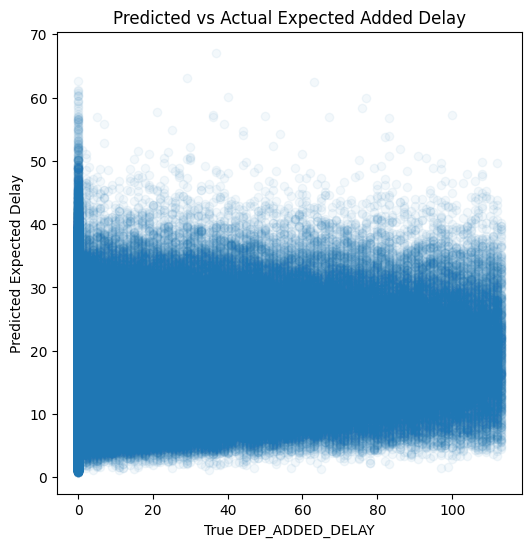

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_added, y_hat_exp, alpha=0.05)
plt.xlabel("True DEP_ADDED_DELAY")
plt.ylabel("Predicted Expected Delay")
plt.title("Predicted vs Actual Expected Added Delay")
plt.show()

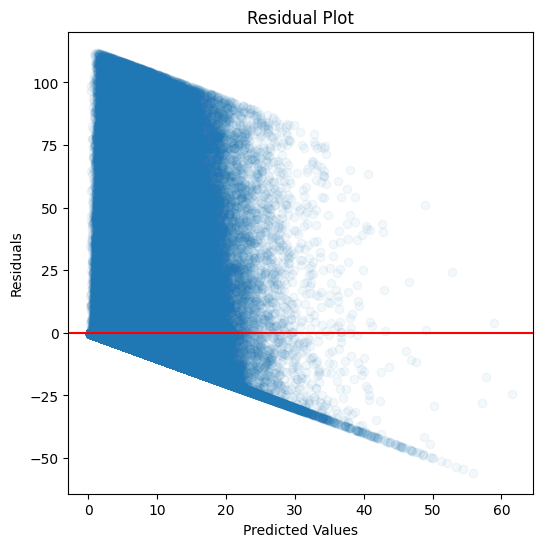

In [ ]:
residuals = y_test_added - y_hat_exp

plt.figure(figsize=(6,6))
plt.scatter(y_hat_exp, residuals, alpha=0.05)
plt.axhline(0, color='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [ ]:
summary_rows = []

# Classification (Logistic Regression for P(delay | X))
summary_rows.append({
    "Model": "Logistic Regression (classification)",
    "Task": "Predict delay indicator (DEP_DEL15)",
    "MAE": None,
    "RMSE/MSE": None,
    "R2": None,
    "Accuracy": results_clf.get("accuracy", None),
    "Precision": results_clf.get("precision", None),
    "Recall": results_clf.get("recall", None),
    "F1": results_clf.get("f1", None)
})

# Regression (Ridge on DEP_ADDED_DELAY, trained on y>0, evaluated on all)
summary_rows.append({
    "Model": "Ridge Regression (severity)",
    "Task": "Predict added delay Y = DEP_ADDED_DELAY",
    "MAE": results_reg.get("mae_all", None),
    "RMSE/MSE": results_reg.get("rmse_all", None),
    "R2": results_reg.get("r2_all", None),
    "Accuracy": None,
    "Precision": None,
    "Recall": None,
    "F1": None
})

# Hurdle expected value (logistic + ridge combined)
summary_rows.append({
    "Model": "Hurdle: p(delay|X) * E[Y | delay, X]",
    "Task": "Predict E[Y | X] for Y = DEP_ADDED_DELAY",
    "MAE": mae_exp,
    "RMSE/MSE": mse_exp,
    "R2": r2_exp,
    "Accuracy": None,
    "Precision": None,
    "Recall": None,
    "F1": None
})

summary_df = pd.DataFrame(summary_rows)
summary_df.set_index("Model", inplace=True)

print("=== Overall Model Summary ===")
display(summary_df)

acc = results_clf.get("accuracy", float("nan"))
prec = results_clf.get("precision", float("nan"))
rec = results_clf.get("recall", float("nan"))
f1 = results_clf.get("f1", float("nan"))

mae_reg = results_reg.get("mae_all", float("nan"))
rmse_reg = results_reg.get("rmse_all", float("nan"))
r2_reg = results_reg.get("r2_all", float("nan"))


=== Overall Model Summary ===


,Task,MAE,RMSE/MSE,R2,Accuracy,Precision,Recall,F1
Model,,,,,,,,
Logistic Regression (classification),Predict delay indicator (DEP_DEL15),NaN,NaN,NaN,0.622545,0.260405,0.646178,0.371214
Ridge Regression (severity),Predict added delay Y = DEP_ADDED_DELAY,19.404793,21.696617,-0.658006,NaN,NaN,NaN,NaN
"Hurdle: p(delay|X) * E[Y | delay, X]",Predict E[Y | X] for Y = DEP_ADDED_DELAY,6.312934,297.168534,-0.046658,NaN,NaN,NaN,NaN


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


AUC: 0.6816


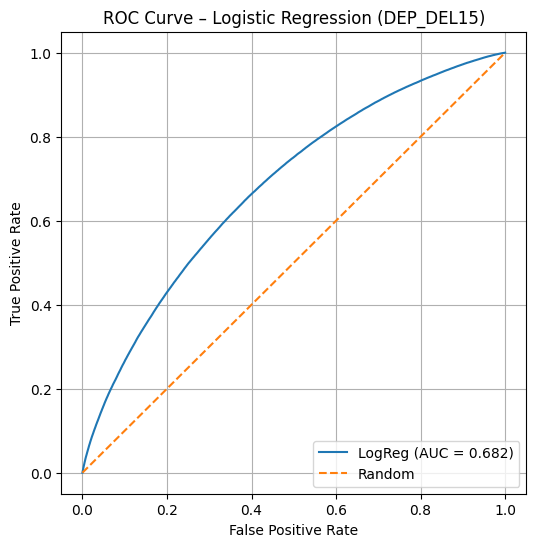

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
y_test = pd.read_csv(y_test_path)['DEP_DEL15'].astype(int).to_numpy()
clf_pipeline = results_clf["pipeline"]
clf_prep = clf_pipeline.preprocessor
clf_model = clf_pipeline.model

X_test = pd.read_csv(X_test_path)
X_test_trans = clf_prep.transform(X_test).astype(np.float32)
y_proba = clf_model.predict_proba(X_test_trans)[:, 1]   # probability of class 1

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

print(f"AUC: {auc:.4f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (DEP_DEL15)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
clf_model

LogisticRegression(C=np.float64(0.1), class_weight='balanced', max_iter=1000,
                   n_jobs=-1)

In [ ]:
X_test

Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'DEP_HOUR', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH',
       'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT',
       'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS',
       'GROUND_SERV_PER_PASS', 'PLANE_AGE', 'DEPARTING_AIRPORT',
       'PREVIOUS_AIRPORT', 'DESTINATION_AIRPORT', 'ROUTE_NAME',
       'INCOMING_ROUTE', 'CARRIER_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'AWND', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07',
       'WT08', 'WT09', 'WT10', 'WT11', 'AWND_missing', 'TMIN_missing',
       'TMAX_missing', 'IS_HEAVY_RAIN', 'IS_SNOWY', 'IS_FREEZING',
       'IS_EXTREME_HEAT', 'SEASON'],
      dtype='object')